In [1]:
import matplotlib.pyplot as plt

# `DotDistortionsDataset` Tutorial

*from "Revisitng Prototype Theory Through Deep Learning" (Sohn, 2022)*

## Introduction

This jupyter notebook is an interactive guide to using `DotDistortionsDataset`.
This dataset closely follows "Visual Search and the Collapse of Categorization"(Smith, 2005) [^1]  [sci-hub link](https://sci-hub.yncjkj.com/10.1037/0096-3445.134.4.443), but is designed to be used in a deep learning context.

This notebook will demonstrate how to create a `DotDistortionsDataset` with well-defined experimental parameters.

[^1]: Smith, J. David; Redford, Joshua S.; Gent, Lauren C.; Washburn, David A.  (2005). Visual Search and the Collapse of Categorization. Journal of Experimental Psychology: General, 134(4), 443–460. doi:10.1037/0096-3445.134.4.443

## Minimal Example

Let's create 16 examples of a single category, with a small amount of distortion.

In [2]:
from DotDistortionsDataset import DotDistortions 

dataset = DotDistortions(
    length = 16,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
)

Since we're starting from scratch, we must call `produce()` on the dataset. This will create the dataset according to the parameters we set above, and save it so that we can load it later.

In [3]:
dataset.produce('temp/mini_dataset.pkl')

In [4]:
dataloader = iter(dataset) # iter() turns a dataset into an iterator, which allows us to fetch consecutive data points using next()

image, bboxes, labels = next(dataloader)

The first image in this dataset:

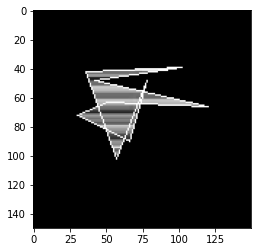

In [5]:
plt.imshow(image, cmap='gray')

Bounding box defines the outermost points on the shape:

In [6]:
bboxes

(30, 39, 120, 102)

Label refers to the category. This number is used to seed random number generator, meaning that the same number will always generate the same basic (unperturbed) shape.

In [7]:
labels

8

Let's see the whole dataset:

In [8]:
# just a little function to show images side-by-side
def show_bunch(
    dataset,
    rows = 2,
    x_figsize=20,
    y_figsize=5,):
    dataset.produce()
    dataloader=iter(dataset)
    fig = plt.figure(figsize=(x_figsize,y_figsize))
    for i in range(len(dataset)):
        image, bboxes, labels = next(dataloader)
        ax = fig.add_subplot(rows, len(dataset)//rows, i+1)
        ax.set_title(str(labels))
        # no ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image, cmap='gray')

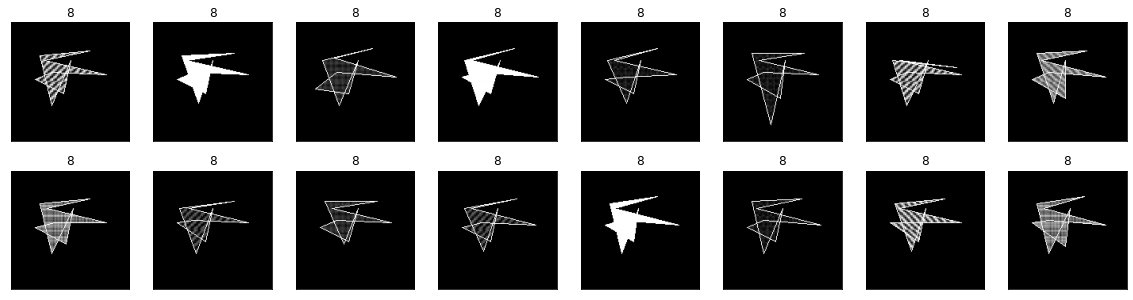

In [9]:
dataset = DotDistortions(
    length = 16,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
)

show_bunch(dataset)

## Playing with Dataset Parameters

### Distortion Level

Notice how the above shapes are all quite similar to each other. It would be pretty easy to learn these shapes from the images.

**What happens if we increase the distortion level?**

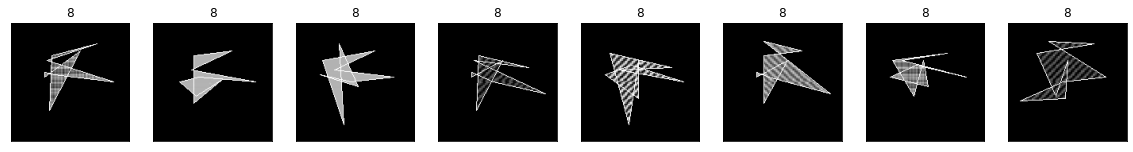

In [10]:
dataset = DotDistortions(
    length = 8,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [8], # pick a favorite number
    num_categories = 1,
    distortion_level = '7.7' # MAXIMUM distortion!
)

show_bunch(dataset, rows=1, x_figsize=20, y_figsize=2.5)

With a high distortion level of '7.7', it becomes harder to see the commonality between the shapes.

Choose from: `'1','2','3','4,'5','6,'7.7'`.

### Categories

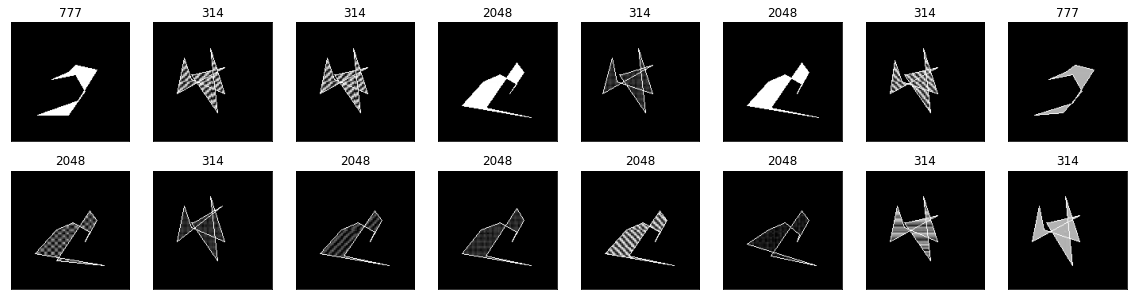

In [11]:
dataset = DotDistortions(
    length = 16,
    train_like = True,
    category_seeds = [2**11, 314, 777], # pick three favorite numbers
    num_categories = 3, # match the number of categories
    distortion_level = '1' # no distortion
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=5)

Supplying the same number into `category_seeds` will always generate the same basic shapes. The order and shading type will always be random.

### Test-like Mode

In the reference literature, subjects were trained to identify single-shape images (shown above). Then, they were shown an image containing 7 mixed shapes containing 0 or 1 shape from the trained categories. Participants were asked to select wheter they saw a trained shape in the test image.

For example, let's say that one of the shapes we were trained to identify was:

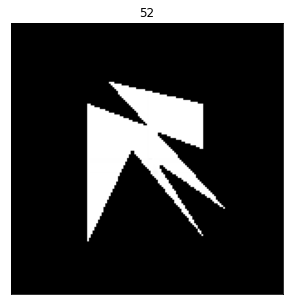

In [12]:
dataset = DotDistortions(
    length = 1,
    train_like = True, # single shape in image, with no distractors
    category_seeds = [52], # pick a favorite number
    num_categories = 1,
)

show_bunch(dataset, rows=1, x_figsize=5, y_figsize=5)

Do you see this shape in each of the test images below?

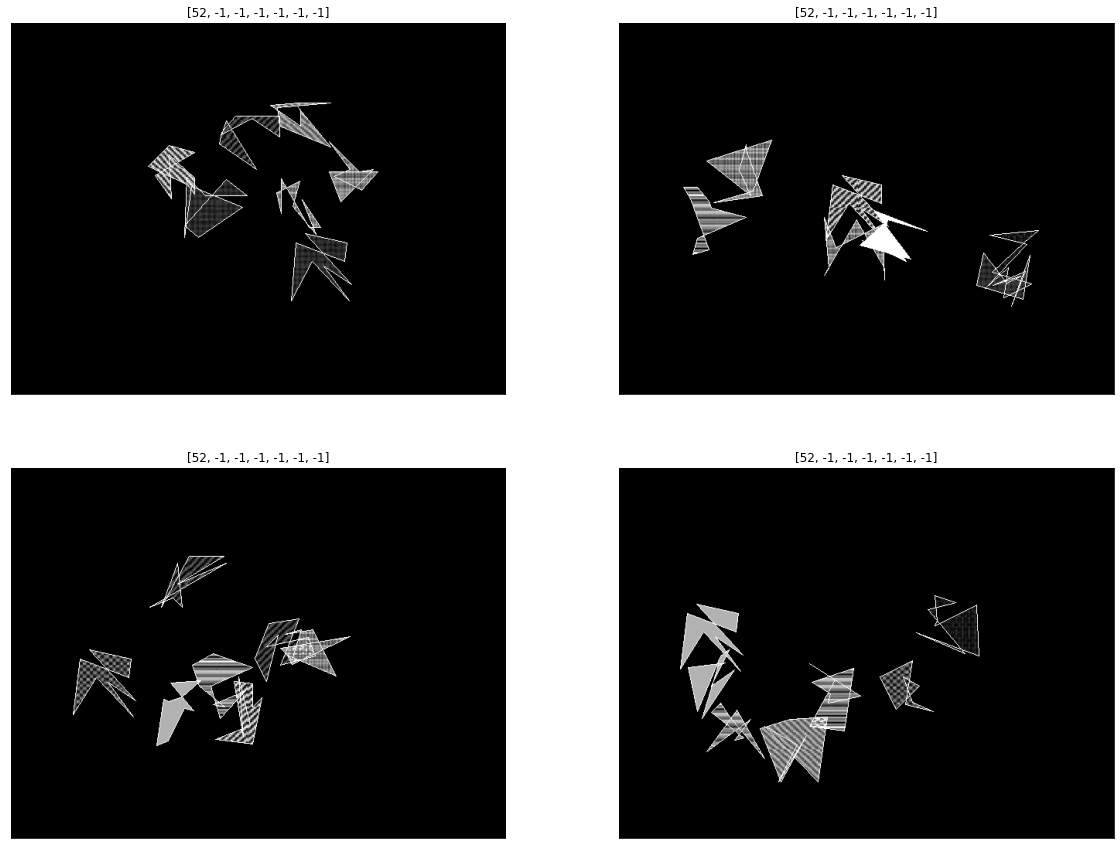

In [13]:
dataset = DotDistortions(
    length = 4,
    train_like = False, # test mode
    category_seeds = [52], 
    num_categories = 1,
    distortion_level = '1', # no distortion; easy mode
    test_like_exists_probability=1.0, # test image will certainly contain a shape of trained category
    total_shapes = 7, # total number of shapes in test image
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=15)

The answer is YES! 

Note: The category numbers of random (non-trained) shapes are all '-1'.

Here are some more examples of test images, but now some do not contain the shape we were trained to identify.

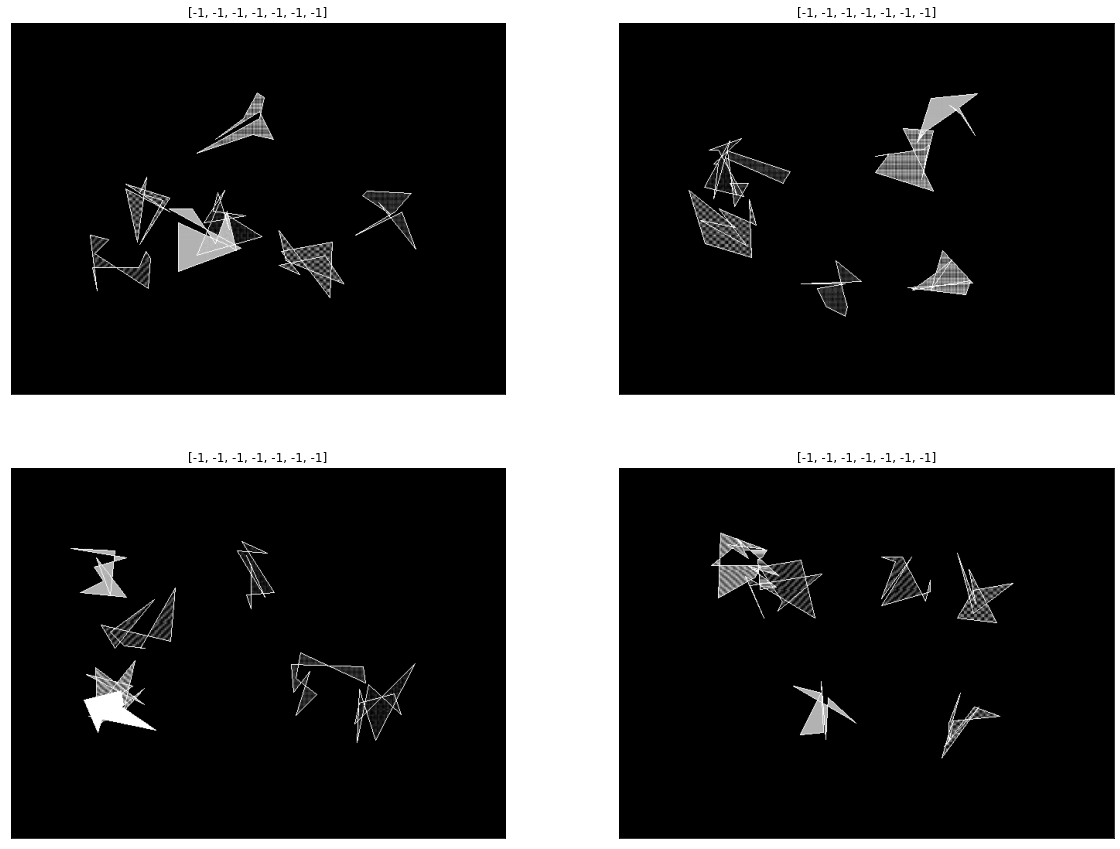

In [14]:
dataset = DotDistortions(
    length = 4,
    train_like = False, # test mode
    category_seeds = [52], 
    num_categories = 1,
    distortion_level = '1', # no distortion; easy mode
    test_like_exists_probability=0.25, # a quarter of the test images will contain a shape of trained category
    total_shapes = 7, # total number of shapes in test image
)

show_bunch(dataset, rows=2, x_figsize=20, y_figsize=15)

To check your guesses, an all-'-1' title means no shapes of the trained categories exist in that test image.

## Conversion to PyTorch Tensor

When using the dataset with PyTorch for deep learning, we need to convert the outputs of our dataset into tensors.
I have made that as easy as setting `torch_transform = True`.

In [15]:
dataset = DotDistortions(
    length = 16,
    train_like = True,
    category_seeds = [37,65,129],
    num_categories = 3, 
    torch_transform = True, # convert output to torch tensors
)

dataset.produce()
image, bboxes, labels = next(iter(dataset)) # get the first image and related data

Just to confirm:

In [16]:
print(type(image))
print(image.shape)

<class 'torch.Tensor'>
torch.Size([150, 150])


In [17]:
print(type(bboxes))
print(bboxes)

<class 'torch.Tensor'>
tensor([ 36,  39, 108, 120])


In [18]:
print(type(labels))
print(labels)

<class 'torch.Tensor'>
tensor(37)


## Saving and Loading Dataset

If you are using this tool in seriousness, you should be keeping track of the parameters you set.

However, even with the exact same parameters, the some features of the dataset will change. (e.g. shading pattern type, location of shapes on test image).

Saving is done automatically when you called `produce()` at the beginning, but if you want to save the dataset yourself, you can do so by calling `save(new_dataset_name.pkl)`.

Therefore, if you want perfect reproducibility, you should save the dataset:



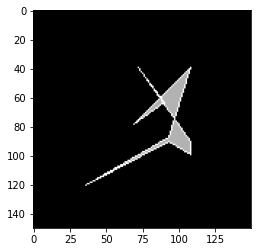

In [19]:
plt.imshow(image, cmap='gray')

In [20]:
dataset.save('temp/demo_dataset.pkl')

Then, when you're ready to work on that same dataset, create an empty dataset, and load the saved dataset pickle file:

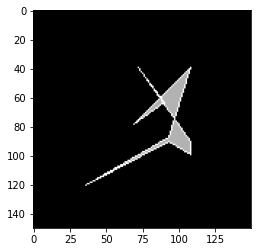

In [21]:
dataset = DotDistortions()
dataset.load('temp/demo_dataset.pkl')

image, bboxes, labels = next(iter(dataset)) # let's see if we loaded it properly

plt.imshow(image, cmap='gray') # should be the same image as above